# MLP - `NoneLinear` Dataset

In [ ]:
! gdown --id 1SqSn_8rxkk-Qvu4JLMcN_3ZFGDNa6P_V -O "data/NonLinear_data.npy"

/home/linhle/miniconda3/envs/py312/lib/python3.12/site-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1SqSn_8rxkk-Qvu4JLMcN_3ZFGDNa6P_V
To: /mnt/d/AIO2024/study_project/AIO2024_Exercises/module05/week03_multilayer_perceptrons/data/NonLinear_data.npy
100%|██████████████████████████████████████| 5.57k/5.57k [00:00<00:00, 17.5MB/s]


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [3]:
random_sate = 59
np.random.seed(random_sate)
torch.manual_seed(random_sate)
if torch.cuda.is_available():
    torch.cuda.manual_seed(random_sate)

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [5]:
data = np.load("data/NonLinear_data.npy", allow_pickle=True).item()

### Data Processing

In [6]:
X, y = data["X"], data["labels"]

X.shape, y.shape

((300, 2), (300,))

In [7]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.2,
    random_state=random_sate,
    shuffle=True
)

X_train, X_test, y_train, y_test = train_test_split(
    X_train, y_train,
    test_size=0.125,
    random_state=random_sate,
    shuffle=True
)

X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

((210, 2), (60, 2), (30, 2), (210,), (60,), (30,))

In [8]:
normalizer = StandardScaler()

X_train = normalizer.fit_transform(X_train)
X_val = normalizer.transform(X_val)
X_test = normalizer.transform(X_test)

X_train = torch.tensor(X_train, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)

y_train = torch.tensor(y_train, dtype=torch.long)
y_val = torch.tensor(y_val, dtype=torch.long)
y_test = torch.tensor(y_test, dtype=torch.long)

### DataLoader

In [9]:
class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
        
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, index):
        return self.X[index], self.y[index]

In [10]:
batch_size = 32

train_dataset = CustomDataset(X_train, y_train)
val_dataset = CustomDataset(X_val, y_val)
test_dataset = CustomDataset(X_test, y_test)


train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

### Accuracy

In [13]:
def compute_accuracy(y_pred, y):
    _, y_pred = torch.max(y_pred, dim=1)
    correct = (y_pred == y).sum().item()
    accuracy = correct / len(y)
    return accuracy

### MLP

In [17]:
class MLP(nn.Module):
    def __init__(self, input_dims, hidden_dims, output_dims):
        super().__init__()
        self.linear1 = nn.Linear(input_dims, hidden_dims)
        self.output = nn.Linear(hidden_dims, output_dims)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = self.linear1(x)
        x = self.relu(x)
        out = self.output(x)
        return out.squeeze(1)

In [19]:
model = MLP(
    input_dims=X_train.shape[1], 
    hidden_dims=128, 
    output_dims=torch.unique(y_train).shape[0]
).to(device)

model

MLP(
  (linear1): Linear(in_features=2, out_features=128, bias=True)
  (output): Linear(in_features=128, out_features=3, bias=True)
  (relu): ReLU()
)

### Loss & Optimizer

In [20]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-1)

### Train

In [22]:
epochs = 100
train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in range(epochs):
    train_loss = 0.0
    train_target, train_predict = [], []
    
    model.train()
    
    for X_samples, y_samples in train_loader:
        X_samples = X_samples.to(device)
        y_samples = y_samples.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(X_samples)
        
        loss = criterion(outputs, y_samples)
        loss.backward()
        
        optimizer.step()    
        
        train_loss += loss.item()
        
        train_predict.append(outputs.detach().cpu())
        train_target.append(y_samples.cpu())

    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    
    train_predict = torch.cat(train_predict)
    train_target = torch.cat(train_target)
    train_acc = compute_accuracy(train_predict, train_target)
    train_accs.append(train_acc)
    
    val_loss = 0.0
    val_target, val_predict = [], []
    model.eval()
    with torch.no_grad():
        for X_samples, y_samples in val_loader:
            X_samples = X_samples.to(device)
            y_samples = y_samples.to(device)
            
            outputs = model(X_samples)
            
            val_loss += criterion(outputs, y_samples).item()
            
            val_predict.append(outputs.cpu())
            val_target.append(y_samples.cpu())
    
    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    
    val_predict = torch.cat(val_predict)
    val_target = torch.cat(val_target)
    val_acc = compute_accuracy(val_predict, val_target)
    val_accs.append(val_acc)
    print(f"\n Epoch {epoch + 1}: \tTraining loss: {train_loss:.3f} \tValidation loss: {val_loss:.3f}")


 Epoch 1: 	Training loss: 0.939 	Validation loss: 0.864

 Epoch 2: 	Training loss: 0.750 	Validation loss: 0.815

 Epoch 3: 	Training loss: 0.715 	Validation loss: 0.799

 Epoch 4: 	Training loss: 0.689 	Validation loss: 0.791

 Epoch 5: 	Training loss: 0.670 	Validation loss: 0.780

 Epoch 6: 	Training loss: 0.654 	Validation loss: 0.747

 Epoch 7: 	Training loss: 0.646 	Validation loss: 0.724

 Epoch 8: 	Training loss: 0.616 	Validation loss: 0.704

 Epoch 9: 	Training loss: 0.616 	Validation loss: 0.694

 Epoch 10: 	Training loss: 0.610 	Validation loss: 0.666

 Epoch 11: 	Training loss: 0.577 	Validation loss: 0.666

 Epoch 12: 	Training loss: 0.596 	Validation loss: 0.642

 Epoch 13: 	Training loss: 0.556 	Validation loss: 0.625

 Epoch 14: 	Training loss: 0.537 	Validation loss: 0.608

 Epoch 15: 	Training loss: 0.521 	Validation loss: 0.604

 Epoch 16: 	Training loss: 0.530 	Validation loss: 0.587

 Epoch 17: 	Training loss: 0.511 	Validation loss: 0.566

 Epoch 18: 	Training l

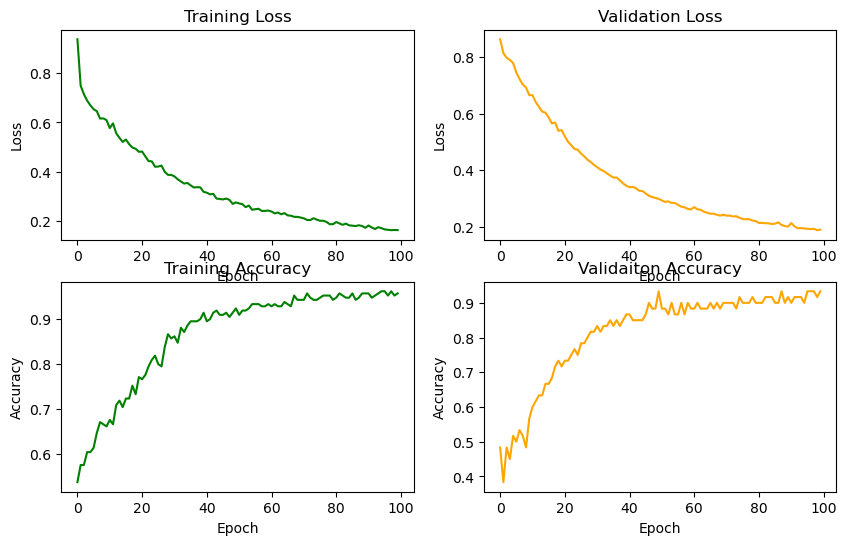

In [26]:
fig, ax = plt.subplots(2, 2, figsize=(10, 6))

ax[0, 0].plot(train_losses, color="green")
ax[0, 0].set(xlabel="Epoch", ylabel="Loss")
ax[0, 0].set_title("Training Loss")

ax[0, 1].plot(val_losses, color="orange")
ax[0, 1].set(xlabel="Epoch", ylabel="Loss")
ax[0, 1].set_title("Validation Loss")

ax[1, 0].plot(train_accs, color="green")
ax[1, 0].set(xlabel="Epoch", ylabel="Accuracy")
ax[1, 0].set_title("Training Accuracy")

ax[1, 1].plot(val_accs, color="orange")
ax[1, 1].set(xlabel="Epoch", ylabel="Accuracy")
ax[1, 1].set_title("Validaiton Accuracy")

plt.show()

### Evaluate

In [27]:
test_target, test_predict = [], []

model.eval()

MLP(
  (linear1): Linear(in_features=2, out_features=128, bias=True)
  (output): Linear(in_features=128, out_features=3, bias=True)
  (relu): ReLU()
)

In [28]:
with torch.no_grad():
    for X_samples, y_samples in test_loader:
        X_samples = X_samples.to(device)
        y_samples = y_samples.to(device)
        
        outputs = model(X_samples)
        
        test_predict.append(outputs.cpu())
        test_target.append(y_samples.cpu())
    test_predict = torch.cat(test_predict)
    test_target = torch.cat(test_target)
    test_acc = compute_accuracy(test_predict, test_target)
    
    print("Evaluation on test set:")
    print(f"Accuracy: {test_acc}")

Evaluation on test set:
Accuracy: 0.9333333333333333


### Question 9.1

In [12]:
class MLP91(nn.Module):
    def __init__(self, input_dims, hidden_dims, output_dims):
        super().__init__()
        self.linear = nn.Linear(input_dims, output_dims)
    
    def forward(self, x):
        return self.linear(x).squeeze(1)

model = MLP91(
    input_dims=X_train.shape[1], 
    hidden_dims=128, 
    output_dims=torch.unique(y_train).shape[0]
).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-1)

epochs = 100
train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in range(epochs):
    train_loss = 0.0
    train_target, train_predict = [], []
    
    model.train()
    
    for X_samples, y_samples in train_loader:
        X_samples = X_samples.to(device)
        y_samples = y_samples.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(X_samples)
        
        loss = criterion(outputs, y_samples)
        loss.backward()
        
        optimizer.step()    
        
        train_loss += loss.item()
        
        train_predict.append(outputs.detach().cpu())
        train_target.append(y_samples.cpu())

    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    
    train_predict = torch.cat(train_predict)
    train_target = torch.cat(train_target)
    train_acc = compute_accuracy(train_predict, train_target)
    train_accs.append(train_acc)
    
    val_loss = 0.0
    val_target, val_predict = [], []
    model.eval()
    with torch.no_grad():
        for X_samples, y_samples in val_loader:
            X_samples = X_samples.to(device)
            y_samples = y_samples.to(device)
            
            outputs = model(X_samples)
            
            val_loss += criterion(outputs, y_samples).item()
            
            val_predict.append(outputs.cpu())
            val_target.append(y_samples.cpu())
    
    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    
    val_predict = torch.cat(val_predict)
    val_target = torch.cat(val_target)
    val_acc = compute_accuracy(val_predict, val_target)
    val_accs.append(val_acc)
    print(f"\n Epoch {epoch + 1}: \tTraining loss: {train_loss:.3f} \tValidation loss: {val_loss:.3f}")

test_target, test_predict = [], []
model.eval()
with torch.no_grad():
    for X_samples, y_samples in test_loader:
        X_samples = X_samples.to(device)
        y_samples = y_samples.to(device)
        
        outputs = model(X_samples)
        
        test_predict.append(outputs.cpu())
        test_target.append(y_samples.cpu())
    test_predict = torch.cat(test_predict)
    test_target = torch.cat(test_target)
    test_acc = compute_accuracy(test_predict, test_target)
    
    print("Evaluation on test set:")
    print(f"Accuracy: {test_acc}")


 Epoch 1: 	Training loss: 1.264 	Validation loss: 1.142

 Epoch 2: 	Training loss: 1.098 	Validation loss: 1.046

 Epoch 3: 	Training loss: 0.990 	Validation loss: 0.981

 Epoch 4: 	Training loss: 0.918 	Validation loss: 0.937

 Epoch 5: 	Training loss: 0.869 	Validation loss: 0.909

 Epoch 6: 	Training loss: 0.837 	Validation loss: 0.890

 Epoch 7: 	Training loss: 0.815 	Validation loss: 0.877

 Epoch 8: 	Training loss: 0.801 	Validation loss: 0.866

 Epoch 9: 	Training loss: 0.781 	Validation loss: 0.860

 Epoch 10: 	Training loss: 0.781 	Validation loss: 0.857

 Epoch 11: 	Training loss: 0.762 	Validation loss: 0.853

 Epoch 12: 	Training loss: 0.752 	Validation loss: 0.851

 Epoch 13: 	Training loss: 0.749 	Validation loss: 0.849

 Epoch 14: 	Training loss: 0.744 	Validation loss: 0.848

 Epoch 15: 	Training loss: 0.755 	Validation loss: 0.848

 Epoch 16: 	Training loss: 0.726 	Validation loss: 0.848

 Epoch 17: 	Training loss: 0.757 	Validation loss: 0.847

 Epoch 18: 	Training l

### Question 9.2

In [14]:
class MLP92(nn.Module):
    def __init__(self, input_dims, hidden_dims, output_dims):
        super().__init__()
        self.linear1 = nn.Linear(input_dims, hidden_dims)
        self.output = nn.Linear(hidden_dims, output_dims)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        x = self.linear1(x)
        x = self.sigmoid(x)
        out = self.output(x)
        return out.squeeze(1)

model = MLP92(
    input_dims=X_train.shape[1], 
    hidden_dims=128, 
    output_dims=torch.unique(y_train).shape[0]
).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-1)

epochs = 100
train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in range(epochs):
    train_loss = 0.0
    train_target, train_predict = [], []
    
    model.train()
    
    for X_samples, y_samples in train_loader:
        X_samples = X_samples.to(device)
        y_samples = y_samples.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(X_samples)
        
        loss = criterion(outputs, y_samples)
        loss.backward()
        
        optimizer.step()    
        
        train_loss += loss.item()
        
        train_predict.append(outputs.detach().cpu())
        train_target.append(y_samples.cpu())

    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    
    train_predict = torch.cat(train_predict)
    train_target = torch.cat(train_target)
    train_acc = compute_accuracy(train_predict, train_target)
    train_accs.append(train_acc)
    
    val_loss = 0.0
    val_target, val_predict = [], []
    model.eval()
    with torch.no_grad():
        for X_samples, y_samples in val_loader:
            X_samples = X_samples.to(device)
            y_samples = y_samples.to(device)
            
            outputs = model(X_samples)
            
            val_loss += criterion(outputs, y_samples).item()
            
            val_predict.append(outputs.cpu())
            val_target.append(y_samples.cpu())
    
    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    
    val_predict = torch.cat(val_predict)
    val_target = torch.cat(val_target)
    val_acc = compute_accuracy(val_predict, val_target)
    val_accs.append(val_acc)
    print(f"\n Epoch {epoch + 1}: \tTraining loss: {train_loss:.3f} \tValidation loss: {val_loss:.3f}")

test_target, test_predict = [], []
model.eval()
with torch.no_grad():
    for X_samples, y_samples in test_loader:
        X_samples = X_samples.to(device)
        y_samples = y_samples.to(device)
        
        outputs = model(X_samples)
        
        test_predict.append(outputs.cpu())
        test_target.append(y_samples.cpu())
    test_predict = torch.cat(test_predict)
    test_target = torch.cat(test_target)
    test_acc = compute_accuracy(test_predict, test_target)
    
    print("Evaluation on test set:")
    print(f"Accuracy: {test_acc}")


 Epoch 1: 	Training loss: 1.113 	Validation loss: 1.064

 Epoch 2: 	Training loss: 0.969 	Validation loss: 0.967

 Epoch 3: 	Training loss: 0.929 	Validation loss: 0.959

 Epoch 4: 	Training loss: 0.843 	Validation loss: 0.926

 Epoch 5: 	Training loss: 0.828 	Validation loss: 0.943

 Epoch 6: 	Training loss: 0.821 	Validation loss: 0.899

 Epoch 7: 	Training loss: 0.778 	Validation loss: 0.918

 Epoch 8: 	Training loss: 0.774 	Validation loss: 0.879

 Epoch 9: 	Training loss: 0.792 	Validation loss: 0.930

 Epoch 10: 	Training loss: 0.779 	Validation loss: 0.873

 Epoch 11: 	Training loss: 0.763 	Validation loss: 0.866

 Epoch 12: 	Training loss: 0.769 	Validation loss: 0.863

 Epoch 13: 	Training loss: 0.761 	Validation loss: 0.926

 Epoch 14: 	Training loss: 0.786 	Validation loss: 1.050

 Epoch 15: 	Training loss: 0.797 	Validation loss: 0.859

 Epoch 16: 	Training loss: 0.749 	Validation loss: 0.868

 Epoch 17: 	Training loss: 0.749 	Validation loss: 0.881

 Epoch 18: 	Training l

### Question 9.3

In [15]:
class MLP93(nn.Module):
    def __init__(self, input_dims, hidden_dims, output_dims):
        super().__init__()
        self.linear1 = nn.Linear(input_dims, hidden_dims)
        self.output = nn.Linear(hidden_dims, output_dims)
        self.tanh = nn.Tanh()
    
    def forward(self, x):
        x = self.linear1(x)
        x = self.tanh(x)
        out = self.output(x)
        return out.squeeze(1)

model = MLP93(
    input_dims=X_train.shape[1], 
    hidden_dims=128, 
    output_dims=torch.unique(y_train).shape[0]
).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-1)

epochs = 100
train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in range(epochs):
    train_loss = 0.0
    train_target, train_predict = [], []
    
    model.train()
    
    for X_samples, y_samples in train_loader:
        X_samples = X_samples.to(device)
        y_samples = y_samples.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(X_samples)
        
        loss = criterion(outputs, y_samples)
        loss.backward()
        
        optimizer.step()    
        
        train_loss += loss.item()
        
        train_predict.append(outputs.detach().cpu())
        train_target.append(y_samples.cpu())

    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    
    train_predict = torch.cat(train_predict)
    train_target = torch.cat(train_target)
    train_acc = compute_accuracy(train_predict, train_target)
    train_accs.append(train_acc)
    
    val_loss = 0.0
    val_target, val_predict = [], []
    model.eval()
    with torch.no_grad():
        for X_samples, y_samples in val_loader:
            X_samples = X_samples.to(device)
            y_samples = y_samples.to(device)
            
            outputs = model(X_samples)
            
            val_loss += criterion(outputs, y_samples).item()
            
            val_predict.append(outputs.cpu())
            val_target.append(y_samples.cpu())
    
    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    
    val_predict = torch.cat(val_predict)
    val_target = torch.cat(val_target)
    val_acc = compute_accuracy(val_predict, val_target)
    val_accs.append(val_acc)
    print(f"\n Epoch {epoch + 1}: \tTraining loss: {train_loss:.3f} \tValidation loss: {val_loss:.3f}")

test_target, test_predict = [], []
model.eval()
with torch.no_grad():
    for X_samples, y_samples in test_loader:
        X_samples = X_samples.to(device)
        y_samples = y_samples.to(device)
        
        outputs = model(X_samples)
        
        test_predict.append(outputs.cpu())
        test_target.append(y_samples.cpu())
    test_predict = torch.cat(test_predict)
    test_target = torch.cat(test_target)
    test_acc = compute_accuracy(test_predict, test_target)
    
    print("Evaluation on test set:")
    print(f"Accuracy: {test_acc}")


 Epoch 1: 	Training loss: 0.869 	Validation loss: 0.879

 Epoch 2: 	Training loss: 0.755 	Validation loss: 0.886

 Epoch 3: 	Training loss: 0.741 	Validation loss: 0.869

 Epoch 4: 	Training loss: 0.741 	Validation loss: 0.853

 Epoch 5: 	Training loss: 0.728 	Validation loss: 0.851

 Epoch 6: 	Training loss: 0.719 	Validation loss: 0.858

 Epoch 7: 	Training loss: 0.728 	Validation loss: 0.841

 Epoch 8: 	Training loss: 0.727 	Validation loss: 0.834

 Epoch 9: 	Training loss: 0.708 	Validation loss: 0.833

 Epoch 10: 	Training loss: 0.688 	Validation loss: 0.827

 Epoch 11: 	Training loss: 0.706 	Validation loss: 0.828

 Epoch 12: 	Training loss: 0.688 	Validation loss: 0.826

 Epoch 13: 	Training loss: 0.689 	Validation loss: 0.813

 Epoch 14: 	Training loss: 0.684 	Validation loss: 0.797

 Epoch 15: 	Training loss: 0.663 	Validation loss: 0.811

 Epoch 16: 	Training loss: 0.669 	Validation loss: 0.807

 Epoch 17: 	Training loss: 0.649 	Validation loss: 0.814

 Epoch 18: 	Training l